In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        anim.save("test.mp4", fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])

        video = open("test.mp4","rb").read()

    anim._encoded_video = video.encode("base64")
    return VIDEO_TAG.format(anim._encoded_video)
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation
sqrt=np.sqrt
pi=np.pi

#애니매이션기능을 하나의 객체로 만든다. TimeAdniation객체를 불러와 속성과 메소드 특성을 바꾼다.
class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        #애니메이션 객체의 그림창과 그래프축창을 만든다.
        fig = plt.figure(figsize=(10.,10.))
        fig.suptitle("The Speed-Torque Curve",fontsize="14")
        ax1 = fig.add_subplot(2, 2, 1)
        plt.grid()
        ax2 = fig.add_subplot(2, 2, 2)
        plt.grid()
        ax3 = fig.add_subplot(2, 1, 2)
        plt.grid()
        #자체 변수값, 시간과 시간에 따라변하는 x,y,z값을 지정한다.
        pole=4
        self.max_rpm=6000
        division=100
        ra=0.26145
        iu=9
        ld=3.3e-3
        lq=6.9e-3
        psi_a=8.3e-2
        vam=100/sqrt(2)
        irms=iu/sqrt(2)
        ia=irms*sqrt(3)
        self.rpm = np.linspace(0, self.max_rpm, division)
        #self.x = np.cos(2 * pi * self.t / 10.)
        #self.y = np.sin(2 * pi * self.t / 10.)
        #self.z = 10 * self.t
        vom=vam-ia*ra
        iam=ia
        id1=np.zeros_like(self.rpm)
        iq1=np.zeros_like(self.rpm)
        self.idd=np.zeros_like(self.rpm)
        self.iqq=np.zeros_like(self.rpm)
        self.beta=np.zeros_like(self.rpm)
        self.torque=np.zeros_like(self.rpm)
        psi_o1=np.zeros_like(self.rpm)
        id1[:] = psi_a / (4 * (lq - ld)) - sqrt((psi_a ** 2) / (16 * (lq - ld) ** 2) + iam ** 2 / 2)
        iq1[:] = sqrt(iam ** 2 - id1 ** 2)
        psi_o1[:] = sqrt((psi_a + ld * id1) ** 2 + (lq * iq1) ** 2)
        omega=2*pi*(self.rpm/60.)*(pole/2)
        omega_base = vom / float(psi_o1[0])
        self.idd[omega<omega_base]=id1[0]
        self.idd[omega>omega_base] = -((psi_a*ld)-sqrt(((psi_a*ld)**2)+(lq**2-ld**2)*(psi_a**2+(lq*iam)**2
                                     -((vom/omega[omega>omega_base])**2))))/(ld**2-lq**2)
        self.iqq=sqrt(iam**2-self.idd**2)
        self.beta=np.rad2deg(np.arctan2(-self.idd,self.iqq))
        self.torque=(pole / 2) * (psi_a * self.iqq + (ld - lq) * self.idd * self.iqq)
        
        ax1.set_xlabel('Id')
        ax1.set_ylabel('Iq')
        #그래프창1에서 사용할 라인들 객체 지정 
        self.line1 = Line2D([], [], color='black')
        self.line1a = Line2D([], [], color='red', linewidth=2)
        self.line1e = Line2D([], [], color='red', marker='o', markeredgecolor='r')
        #만들어진 라인들을 그래프창에 추가한다.
        ax1.add_line(self.line1)
        ax1.add_line(self.line1a)
        ax1.add_line(self.line1e)
        #그래프창 범위지정
        ax1.set_xlim(-np.abs(np.min(self.idd)*sqrt(2)), 0)
        ax1.set_ylim(0, np.abs(np.min(self.idd)*sqrt(2)))
        
        #그래프창 사이즈 비율지정 
        ax1.set_aspect('equal', 'datalim')

        ax2.set_xlabel('rpm')
        ax2.set_ylabel('beta')
        self.line2 = Line2D([], [], color='black')
        self.line2a = Line2D([], [], color='red', linewidth=2)
        self.line2e = Line2D([], [], color='red', marker='o', markeredgecolor='r')
        ax2.add_line(self.line2)
        ax2.add_line(self.line2a)
        ax2.add_line(self.line2e)
        ax2.set_xlim(0, self.max_rpm)
        ax2.set_ylim(0, 90)
        

        ax3.set_xlabel('rpm')
        ax3.set_ylabel('Torque')
        self.line3 = Line2D([], [], color='black')
        self.line3a = Line2D([], [], color='red', linewidth=2)
        self.line3e = Line2D([], [], color='red', marker='o', markeredgecolor='r')
        ax3.add_line(self.line3)
        ax3.add_line(self.line3a)
        ax3.add_line(self.line3e)
        ax3.set_xlim(0, self.max_rpm)
        ax3.set_ylim(0, np.max(self.torque)*1.25)
        

        animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)
    def _draw_frame(self, framedata):
        i = framedata
        head = i - 1
        head_len = 10
        a=self.rpm[6]
        head_slice = (self.rpm > self.rpm[i] - a) & (self.rpm < self.rpm[i])

        self.line1.set_data(self.idd[:i], self.iqq[:i])
        self.line1a.set_data(self.idd[head_slice], self.iqq[head_slice])
        self.line1e.set_data(self.idd[head], self.iqq[head])

        self.line2.set_data(self.rpm[:i], self.beta[:i])
        self.line2a.set_data(self.rpm[head_slice], self.beta[head_slice])
        self.line2e.set_data(self.rpm[head], self.beta[head])

        self.line3.set_data(self.rpm[:i], self.torque[:i])
        self.line3a.set_data(self.rpm[head_slice], self.torque[head_slice])
        self.line3e.set_data(self.rpm[head], self.torque[head])

        self._drawn_artists = [self.line1, self.line1a, self.line1e,
            self.line2, self.line2a, self.line2e,
            self.line3, self.line3a, self.line3e]

    def new_frame_seq(self):
        return iter(range(self.rpm.size))

    def _init_draw(self):
        lines =  [self.line1, self.line1a, self.line1e,
            self.line2, self.line2a, self.line2e,
            self.line3, self.line3a, self.line3e]
        for l in lines:
            l.set_data([], [])



ani = SubplotAnimation()
ani.save('test_sub.mp4')
display_animation(ani)

In [10]:
np.sqrt(2)

1.4142135623730951

In [65]:
a=np.linspace(0,100,100)
r=np.zeros_like(a)
r[(20<a)&(a<50)]=1
r

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

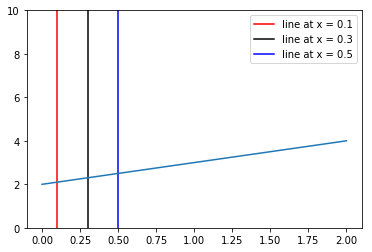

In [3]:
import matplotlib.pyplot as plt

xcoords = [0.1, 0.3, 0.5]
colors = ['r','k','b']

for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc, label='line at x = {}'.format(xc), c=c)
plt.plot([2,3,4])
plt.legend()
plt.ylim([0,10])
plt.show()